In [1]:
import numpy as np
from pathlib import Path

from pymor.basic import *
from pymor.core.pickle import load

from RBInvParam.problems.problems import build_InstationaryModelIP

set_log_levels({
    'pymor' : 'WARN'
})

set_defaults({})


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 10,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs} \usepackage{bm}',
    'figure.dpi': 200
})

In [5]:
WORK_DIR = Path('/run/media/benedikt/38E84473425D444F/Dokumente/Studium/Mathematik/PhD/parabolische_inverse_probleme')
#WORK_DIR = Path('/home/benedikt/Dokumente/parabolische_inverse_probleme')
#SAVE_PATH = Path('/run/media/benedikt/38E84473425D444F/Dokumente/Studium/Mathematik/PhD/Papers/parabolische_inverse_probleme/figures/experiments')
#SAVE_PATH = Path('/home/benedikt/Dokumente/Paper/parabolische_inverse_probleme/figures/experiments')

data_dir_path = WORK_DIR / Path('experiments/enforce_adm_region_corrected_suff_cond')

FOM_data_path = WORK_DIR / Path('experiments/enforce_adm_region_corrected_suff_cond') / 'diffusion_FOM_300_time_dep'
TR_data_path = WORK_DIR / Path('experiments/test_enrichment_strategy_new') / 'diffusion_TR_time_dep_1e-12'

# FOM_data_path = data_dir_path / 'reaction_FOM_300_non_time_dep'
# TR_data_path = data_dir_path / 'reaction_TR_300_non_time_dep'

# FOM_data_path = data_dir_path / 'diffusion_FOM_300_non_time_dep'
# TR_data_path = data_dir_path / 'diffusion_TR_300_non_time_dep'

# FOM_data_path = data_dir_path / 'reaction_FOM_300_time_dep'
# TR_data_path = data_dir_path / 'reaction_TR_300_time_dep'

# FOM_data_path = data_dir_path / 'diffusion_FOM_300_time_dep'
# TR_data_path = data_dir_path / 'diffusion_TR_300_time_dep'

setup_path = FOM_data_path / 'setup.pkl'
optimizer_parameter_path = FOM_data_path / 'optimizer_parameter.pkl'


with open(setup_path, 'rb') as file:
    setup = load(file)

with open(optimizer_parameter_path, 'rb') as file:
    optimizer_parameter = load(file)

if not 'FOM' in locals():
    FOM, grid_data, assembled_products = build_InstationaryModelIP(setup=setup)

    

data = {}

if FOM_data_path:
    with open(FOM_data_path / 'FOM_IRGNM_final.pkl', 'rb') as file:
        FOM_data = load(file)
    data['FOM'] = FOM_data

if TR_data_path:
    with open(TR_data_path / 'TR_IRGNM_final.pkl', 'rb') as file:
        TR_data = load(file)
    data['TR'] = TR_data
    


In [ ]:
import copy
#data_reaction = copy.deepcopy(data)
data_diffusion = copy.deepcopy(data)

In [7]:
from RBInvParam.products import BochnerProductOperator

q_FOM = data['FOM']['q'][-1]
q_TR = data['TR']['q'][-1]

nt = setup['dims']['nt']
#nt = 1

bochner_L2 = BochnerProductOperator(
    product=NumpyMatrixOperator(
        matrix = assembled_products['l2'],
        source_id = FOM.Q.id,
        range_id = FOM.Q.id
    ),
    delta_t=setup['model_parameter']['delta_t'],
    space = FOM.Q,
    nt = nt
)

print("L2 rel error:")
result = np.sqrt(bochner_L2.apply2(q_FOM-q_TR, q_FOM-q_TR)[0,0]) / np.sqrt(bochner_L2.apply2(q_FOM, q_FOM)[0,0]) * 100
print(f"{result:.2f}")


bochner_H1 = BochnerProductOperator(
    product=NumpyMatrixOperator(
        matrix = assembled_products['h1'],
        source_id = FOM.Q.id,
        range_id = FOM.Q.id
    ),
    delta_t=setup['model_parameter']['delta_t'],
    space = FOM.Q,
    nt = nt
)

print("H1 rel error:")
result = np.sqrt(bochner_H1.apply2(q_FOM-q_TR, q_FOM-q_TR)[0,0]) / np.sqrt(bochner_H1.apply2(q_FOM, q_FOM)[0,0]) * 100
print(f"{result:.2f}")



L2 rel error:
0.44
H1 rel error:
4.55


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    "font.size": 14,
})

title_pad = 5

time_step = 25
time_dep = True

# time_step = 0
# time_dep = False

fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)  # Create 3 subplots
ax0, ax1, ax2 = axes
ax = [ax0, ax1, ax2]

centers = grid_data['grid'].centers(codim=2)
triang = tri.Triangulation(centers[:, 0], centers[:, 1])

# Extract data
#q_exact = setup['model_parameter']['q_exact'].to_numpy()[time_step, :]
q_exact = FOM.setup['model_parameter']['q_exact'].to_numpy()[time_step, :]
q_FOM = data['FOM']['q'][-1].to_numpy()[time_step, :]
q_TR = data['TR']['q'][-1].to_numpy()[time_step, :]

# Compute min and max over all values
q_all = np.concatenate([q_exact, q_FOM, q_TR])
vmin, vmax = np.min(q_all), np.max(q_all)

# Plot tripcolor for each subplot
ax[0].tripcolor(triang, q_exact, cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)
ax[1].tripcolor(triang, q_FOM, cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)
c = ax[2].tripcolor(triang, q_TR, cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# Titles
if time_dep:
    ax[0].set_title(r'$\bm{q}^{' + str(time_step) + r'}_\mathsf e$', pad=title_pad)
    ax[1].set_title(r'$\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}$', pad=title_pad)
    ax[2].set_title(r'$\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize TR}$', pad=title_pad)
else:
    ax[0].set_title(r'$\bm{q}_\mathsf e$', pad=title_pad)
    ax[1].set_title(r'$\bm{q}_\textrm{\footnotesize FOM}$', pad=title_pad)
    ax[2].set_title(r'$\bm{q}_\textrm{\footnotesize TR}$', pad=title_pad)

# Remove ticks and set aspect ratio
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.set_aspect('equal')
    ax_.set_xlim(0, 1)
    ax_.set_ylim(0, 1)

# Create an axis divider for the last axis
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size & padding for colorbar

# Add colorbar
fig.colorbar(c, cax=cax)

# Save and show
fig.savefig(SAVE_PATH / Path(f'run_4.pdf'), bbox_inches="tight")
#fig.savefig(SAVE_PATH / Path(f'run_3_{time_step}.pdf'), bbox_inches="tight")
#fig.savefig(SAVE_PATH / Path(f'run_4_{time_step}.pdf'), bbox_inches="tight")
plt.show()

plt.rcParams.update({
    "font.size": 10,
})


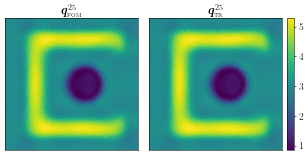

In [11]:

# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "cm",
#     "font.size": 14,
#     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs} \usepackage{bm}',
#     'figure.dpi': 50
# })

# title_pad = 5

# time_step = 25
# time_dep = True

# # time_step = 0
# # time_dep = False

# fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)  # Create 3 subplots
# ax0, ax1 = axes
# ax = [ax0, ax1]

# centers = grid_data['grid'].centers(codim=2)
# triang = tri.Triangulation(centers[:, 0], centers[:, 1])

# # Extract data
# #q_exact = setup['model_parameter']['q_exact'].to_numpy()[time_step, :]
# q_exact = FOM.setup['model_parameter']['q_exact'].to_numpy()[time_step, :]
# q_FOM = data['FOM']['q'][-1].to_numpy()[time_step, :]
# q_TR = data['TR']['q'][-1].to_numpy()[time_step, :]

# # Compute min and max over all values
# q_all = np.concatenate([q_exact, q_FOM, q_TR])
# vmin, vmax = np.min(q_all), np.max(q_all)

# # Plot tripcolor for each subplot
# ax[0].tripcolor(triang, q_FOM, cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)
# c = ax[1].tripcolor(triang, q_TR, cmap='viridis', shading='gouraud', vmin=vmin, vmax=vmax)

# # Titles
# if time_dep:
#     ax[0].set_title(r'$\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}$', pad=title_pad)
#     ax[1].set_title(r'$\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize TR}$', pad=title_pad)
# else:
#     ax[0].set_title(r'$\bm{q}_\textrm{\footnotesize FOM}$', pad=title_pad)
#     ax[1].set_title(r'$\bm{q}_\textrm{\footnotesize TR}$', pad=title_pad)

# # Remove ticks and set aspect ratio
# for ax_ in ax:
#     ax_.set_xticks([])
#     ax_.set_yticks([])
#     ax_.set_aspect('equal')
#     ax_.set_xlim(0, 1)
#     ax_.set_ylim(0, 1)

# # Create an axis divider for the last axis
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size & padding for colorbar

# # Add colorbar
# fig.colorbar(c, cax=cax)

# # Save and show
# fig.savefig(Path(f'./run_4_pres.pdf'), bbox_inches="tight")
# #fig.savefig(SAVE_PATH / Path(f'run_3_{time_step}.pdf'), bbox_inches="tight")
# #fig.savefig(SAVE_PATH / Path(f'run_4_{time_step}.pdf'), bbox_inches="tight")
# plt.show()

# plt.rcParams.update({
#     "font.size": 10,
# })


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the viridis colormap for consistent coloring
cmap = plt.cm.viridis
colors = [cmap(0.2), cmap(0.6), cmap(0.9)]  # Three distinct colors from viridis

fig, ax = plt.subplots(figsize=(8, 5))  # Set a good figure size

############################# FOM #############################

total_runtime = np.array([0])
total_runtime = np.append(total_runtime, data['FOM']['total_runtime'][:-1])

J = np.array(data['FOM']['J'])
J = np.sqrt(2 * J)

ax.plot(total_runtime, J, marker='o', linestyle='-', markersize=6, 
        color=colors[0], label='FOM')  # Darker viridis tone

############################# TR #############################

total_runtime = np.array([0])
total_runtime = np.append(total_runtime, data['TR']['total_runtime'][:-1])

J = np.array(data['TR']['J'])
J = np.sqrt(2 * J)

ax.plot(total_runtime, J, marker='s', linestyle='-', markersize=6, 
        color=colors[1], label='TR')  # Mid-tone viridis

############################# hline #############################

tau = optimizer_parameter['tau']
noise_level = optimizer_parameter['noise_level']
tol = optimizer_parameter['tol']
y = tau * noise_level + tol
ax.axhline(y=y, color=colors[2], linestyle='--', linewidth=1.5, label=r'Threshold')  # Light viridis tone

############################# layout #############################

ax.set_xlabel(r'time [s]', fontsize=12)
ax.set_ylabel(r'$\|\mathcal{F}_h(q_h^(i))-y_h^{\delta}\|_C$', fontsize=12)
ax.set_yscale('log')

ax.set_xlim(left=0)  # Ensure x-axis starts at 0
ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    "font.size": 14,
})

def plot_q_diffs(data, ax):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])
    
    # Extract the arrays
    q_FOM = data['FOM']['q'][-1].to_numpy()[time_step, :]
    q_TR = data['TR']['q'][-1].to_numpy()[time_step, :]

    q_all = np.concatenate([q_FOM, q_TR])

    # Compute min and max over all values
    vmin, vmax = np.min(q_all), np.max(q_all)

    return ax.tripcolor(triang, np.abs(q_FOM - q_TR), cmap='viridis', shading='gouraud')

title_pad = 7

# time_step = 0
# time_dep = False

time_step = 25
time_dep = True

fig, axes = plt.subplots(1, 2, figsize=(7.2, 3), constrained_layout=True)

for i, (ax, data) in enumerate(zip(axes, [data_reaction, data_diffusion])):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)  # Adjust padding to reduce distance
    c = plot_q_diffs(data, ax)
    fig.colorbar(c, cax=cax, aspect=20, shrink=1.0)  # Ensuring same height

    # Formatting the plots
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

if time_dep:
    axes[0].set_title(r'Run 3: $|\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}- \bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize TR}|$', pad=title_pad)
    axes[1].set_title(r'Run 4: $|\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}- \bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize TR}|$', pad=title_pad)
else:
    axes[0].set_title(r'Run 1: $|\bm{q}_\textrm{\footnotesize FOM} - \bm{q}_\textrm{\footnotesize TR}|$', pad=title_pad)
    axes[1].set_title(r'Run 2: $|\bm{q}_\textrm{\footnotesize FOM} - \bm{q}_\textrm{\footnotesize TR}|$', pad=title_pad)

#fig.tight_layout()
#fig.show()
#fig.savefig(SAVE_PATH / Path('diffs_run_1_and_2.pdf'),  bbox_inches="tight")
fig.savefig(SAVE_PATH / Path('diffs_run_3_and_4.pdf'),  bbox_inches="tight")


plt.rcParams.update({
    "font.size": 10,
})

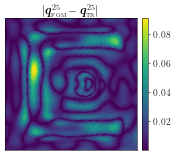

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cm",
    "font.size": 14,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{accents} \usepackage{mathrsfs} \usepackage{bm}',
    'figure.dpi': 50
})

def plot_q_diffs(data, ax):
    centers = grid_data['grid'].centers(codim=2)
    triang = tri.Triangulation(centers[:, 0], centers[:, 1])
    
    # Extract the arrays
    q_FOM = data['FOM']['q'][-1].to_numpy()[time_step, :]
    q_TR = data['TR']['q'][-1].to_numpy()[time_step, :]

    q_all = np.concatenate([q_FOM, q_TR])

    # Compute min and max over all values
    vmin, vmax = np.min(q_all), np.max(q_all)

    return ax.tripcolor(triang, np.abs(q_FOM - q_TR), cmap='viridis', shading='gouraud')

title_pad = 7

# time_step = 0
# time_dep = False

time_step = 25
time_dep = True

fig, axes = plt.subplots(1, 1, figsize=(3.6, 3), constrained_layout=True)
axes = [axes]

for i, (ax, data) in enumerate(zip(axes, [data])):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)  # Adjust padding to reduce distance
    c = plot_q_diffs(data, ax)
    fig.colorbar(c, cax=cax, aspect=20, shrink=1.0)  # Ensuring same height

    # Formatting the plots
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

axes[0].set_title(r'$|\bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize FOM}- \bm{q}^{' + str(time_step) + r'}_\textrm{\footnotesize TR}|$', pad=title_pad)


#fig.tight_layout()
#fig.show()
#fig.savefig(SAVE_PATH / Path('diffs_run_1_and_2.pdf'),  bbox_inches="tight")
fig.savefig(Path('./diffs_4.pdf'),  bbox_inches="tight")


plt.rcParams.update({
    "font.size": 10,
})

In [ ]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({
    "font.size": 12,
})


fig = plt.figure(figsize=(9, 3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Last column for colorbar

y_lim = [1e-5, 1e-2]

def plot_decays(data : Dict, ax) -> None:
    
    ############################# FOM #############################

    total_runtime = np.array([0])
    total_runtime = np.append(total_runtime, data['FOM']['total_runtime'][:-1])
    
    J = np.array(data['FOM']['J'])
    J = np.sqrt(2 * J)
    
    ax.plot(total_runtime, J, marker='o', linestyle='-', markersize=6, 
            color=colors[0], label='FOM')  # Darker viridis tone
    
    ############################# TR #############################
    
    total_runtime = np.array([0])
    total_runtime = np.append(total_runtime, data['TR']['total_runtime'][:-1])
    
    J = np.array(data['TR']['J'])
    J = np.sqrt(2 * J)
    
    ax.plot(total_runtime, J, marker='s', linestyle='-', markersize=6, 
            color=colors[1], label='TR')  # Mid-tone viridis
    
    ############################# hline #############################
    
    tau = optimizer_parameter['tau']
    noise_level = optimizer_parameter['noise_level']
    tol = optimizer_parameter['tol']
    y = tau * noise_level + tol
    ax.axhline(y=y, color=colors[2], linestyle='--', linewidth=1.5, label=r'Threshold')  # Light viridis tone

    ############################# layout #############################

    ax.set_xlabel(r'time [s]', fontsize=12)
    ax.set_yscale('log')
    
    ax.set_xlim(left=0)  # Ensure x-axis starts at 0
    ax.set_ylim(y_lim)  # Ensure x-axis starts at 0
    ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

    
# Use the viridis colormap for consistent coloring
cmap = plt.cm.viridis
colors = [cmap(0.2), cmap(0.6), cmap(0.9)]  # Three distinct colors from viridis

plot_decays(data = data_reaction, ax = plt.subplot(gs[0]))
plot_decays(data = data_diffusion, ax = plt.subplot(gs[1]))

############################# layout #############################
ax = plt.subplot(gs[0])
ax.set_ylabel(r'$\|\mathcal{F}_h(q_h^{(i)})-y_h^{\delta}\|_C$', fontsize=12)
ax.set_title('Run 1')
#ax.set_title('Run 3')

ax = plt.subplot(gs[1])
ax.legend(loc='best', fontsize=10)
ax.set_title('Run 2')
#ax.set_title('Run 4')


fig.tight_layout()  # Adjust layout for better spacing
fig.savefig(SAVE_PATH / Path('decays_run_1_and_2.pdf'),  bbox_inches="tight")
#fig.savefig(SAVE_PATH / Path('decays_run_3_and_4.pdf'),  bbox_inches="tight")
